## Indego Project 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
import datetime as dt
from pandas.api.types import CategoricalDtype
import folium
import os.path
import io
from PIL import Image, ImageDraw, ImageFont
import os
from IPython.display import Video


In [2]:
df = pd.read_csv("/Users/karimaidrissi/Desktop/DSSA 5001/indego.csv")

In [3]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,320093117,30,7/1/19 0:01,7/1/19 0:31,3049,39.945091,-75.142502,3121,39.974140,-75.180222,11901,30,One Way,Indego30,standard
1,320093114,26,7/1/19 0:04,7/1/19 0:30,3119,39.966740,-75.207993,3118,39.958660,-75.213226,16519,30,One Way,Indego30,electric
2,320093115,10,7/1/19 0:04,7/1/19 0:14,3043,39.930820,-75.174744,3155,39.940182,-75.154419,2729,365,One Way,Indego365,standard
3,320093116,10,7/1/19 0:04,7/1/19 0:14,3043,39.930820,-75.174744,3155,39.940182,-75.154419,2603,30,One Way,Indego30,standard
4,320093113,15,7/1/19 0:05,7/1/19 0:20,3040,39.962891,-75.166061,3007,39.945171,-75.159927,11868,1,One Way,Day Pass,standard


In [4]:
# converting time string into Datetime
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])
# extract the hour from start time:
df["hour"] = df.start_time.dt.hour
#df["hour"]  = df["start_time"].map(lambda x: x.hour)

# extract the minute from start time:
df["minute"] = df.start_time.dt.minute
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,hour,minute
0,320093117,30,2019-07-01 00:01:00,2019-07-01 00:31:00,3049,39.945091,-75.142502,3121,39.974140,-75.180222,11901,30,One Way,Indego30,standard,0,1
1,320093114,26,2019-07-01 00:04:00,2019-07-01 00:30:00,3119,39.966740,-75.207993,3118,39.958660,-75.213226,16519,30,One Way,Indego30,electric,0,4
2,320093115,10,2019-07-01 00:04:00,2019-07-01 00:14:00,3043,39.930820,-75.174744,3155,39.940182,-75.154419,2729,365,One Way,Indego365,standard,0,4
3,320093116,10,2019-07-01 00:04:00,2019-07-01 00:14:00,3043,39.930820,-75.174744,3155,39.940182,-75.154419,2603,30,One Way,Indego30,standard,0,4
4,320093113,15,2019-07-01 00:05:00,2019-07-01 00:20:00,3040,39.962891,-75.166061,3007,39.945171,-75.159927,11868,1,One Way,Day Pass,standard,0,5


In [6]:
# checking how many NA in our data :
df[['start_lat','start_lon', 
    'end_lat', 'end_lon']].isna().sum()


start_lat     350
start_lon     350
end_lat      3444
end_lon      3444
dtype: int64

In [7]:
# remove NA entries:
df.dropna(subset=['start_lat', 'start_lon', 'end_lat', 'end_lon'], inplace=True)

In [8]:
# I will use folium, nice package for geographical data
# pull up the map of Philadelphia using latitude and longtitude from latlong.net website:
folium_map = folium.Map(location=[39.952583,-75.165222],
                        zoom_start=13,
                        tiles='cartodbdark_matter')

# adding cirlce marker:
marker = folium.CircleMarker(location=[39.952583,-75.165222],color="green",fill=True)
marker.add_to(folium_map)
folium_map


In [9]:
# counting how many trips for start_station and end_station:
def counting_by_hour(hour,df):
    locations = df.groupby("start_station").first()
    locations = locations.loc[:, ["start_lat",
                                  "start_lon"]]
    # select one time of day:
    subset = df[df["hour"]==hour]
    
    #count trips for each destination
    departure_count = subset.groupby('start_station').count()
    departure_count = departure_count.iloc[:,[0]]
    departure_count.columns = ["Departure Count"]
    
    # count trip for origin:
    arrival_count = subset.groupby("end_station").count().iloc[:,[0]]
    arrival_count.columns = ["Arrival Count"]
    
    # Join the departure counts, arrival counts and locations:
    trip_counts = departure_count.join(locations).join(arrival_count)
    return trip_counts

# print trip count by 7 am
counting_by_hour(7,df).head()


,Departure Count,start_lat,start_lon,Arrival Count
start_station,,,,
3004,20,39.953781,-75.163742,225.0
3005,52,39.947330,-75.144028,45.0
3006,32,39.952202,-75.203110,35.0
3007,339,39.945171,-75.159927,101.0
3008,24,39.980782,-75.150551,26.0


In [10]:
# Plotting markers for each station and assign color depending on departure
# if the the departure more than arrivals we color yellow
# else we color green 
def plot_station_counts(trip_counts):
    # generate a new map
    folium_map = folium.Map(location=[39.952583,-75.165222],
                            zoom_start=13,
                            tiles="cartodbdark_matter")
# counting net_departures:
    for index, row in trip_counts.iterrows():
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
# radius of cirlces:
        radius = net_departures/10
# choose the color of the marker:        
        if net_departures>0:
            color="yellow"
        else:
            color="green"
# add the cirlce marker to the map            
        folium.CircleMarker(location=(row["start_lat"],
                                  row["start_lon"]),
                                  radius=radius,
                                  color=color,
                                  fill=True).add_to(folium_map)
    return folium_map

In [11]:
# plot the departures at 8AM
trip_counts = counting_by_hour(8,df)
plot_station_counts(trip_counts)

In [12]:
# plot the trip count by 6 pm
trip_counts = counting_by_hour(18,df)
plot_station_counts(trip_counts)

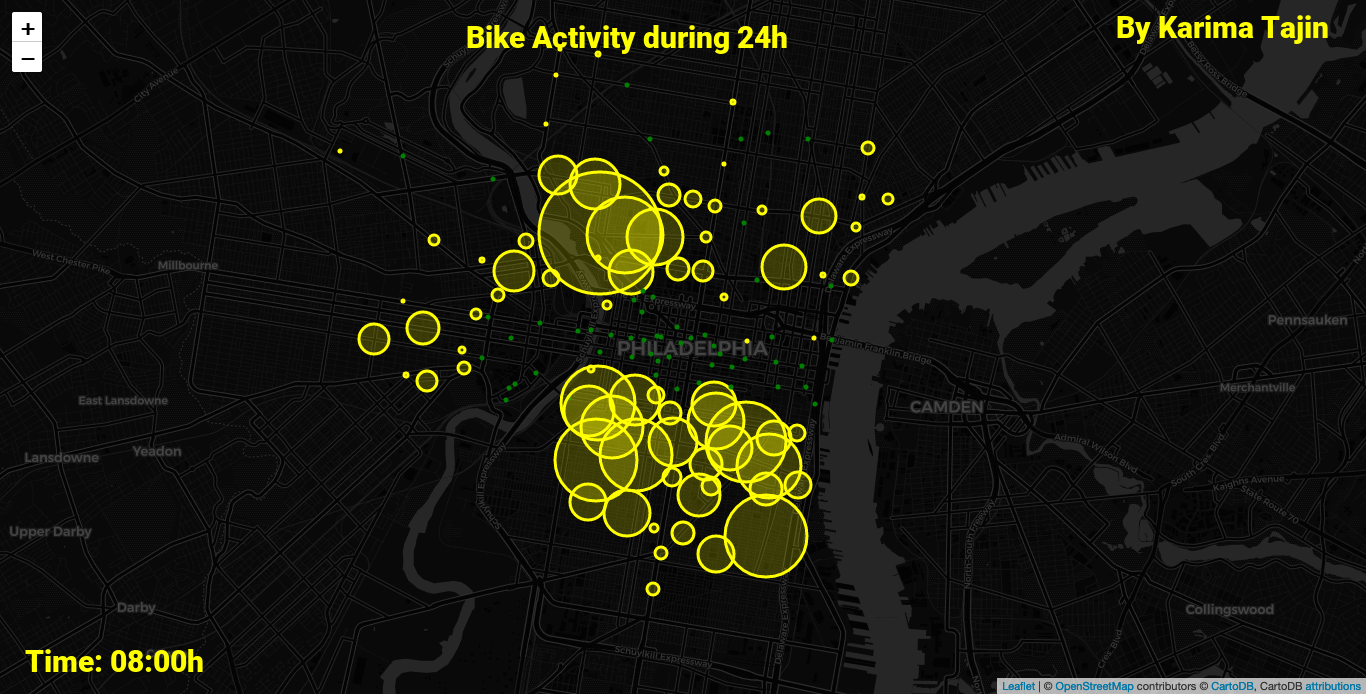

In [41]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = counting_by_hour(hour_of_day, df)
    Map = plot_station_counts(data)
    
    # generate the png file as a byte array
    png = Map._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype('/Users/karimaidrissi/Desktop/Roboto-Black.ttf', size =30)
    
    # draw time of day text
    color = "yellow"
    draw.text((25,image.height - 50),"Time: {:0>2}:{:0>2}h".format(hour, minutes), fill= color, font=font)
    
    # draw title
    draw.text((image.width - 900,20), "Bike Activity during 24h", fill= color, font=font)
    draw.text((image.width - 250,10),"By Karima Tajin", fill= color, font=font)
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image
dir_name = "/Users/karimaidrissi/Desktop/bike"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
go_arrivals_frame(1, 8, dir_name)

In [42]:
# we will extract many images by generating a loop:
arrival_times = np.arange(0, 24)
for i, hour in enumerate(arrival_times):
    go_arrivals_frame(i, hour, "/Users/karimaidrissi/Desktop/bike")

In [ ]:
# we will convert many images into a movie by using ffmpeg:
ffmpeg -r 1 -i file3/frame_%05d.png -c:v libx264 -vf fps=25 -crf 17 -pix_fmt yuv420p output.mp4

In [ ]:
# using ffmpeg to add mp3 to the video:
Karimas-MBP:bike karimaidrissi$ ffmpeg -r 1 -i frame_%05d.png -i MP3FILE.mp3 -c:v libx264 -vf fps=20 -crf 17 -pix_fmt yuv420p bike.mp4

In [225]:
# display Bike video: 
from IPython.display import Video
Video("bike.mp4", embed =True)